In [1]:
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from models import DiTBlock, get_2d_sincos_pos_embed, TimestepEmbedder


In [2]:
bs = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class TransformerBackbone(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int, num_layers: int, num_heads: int, mlp_dim: int, 
                 num_experts: int = 4, active_experts: int = 2, dropout: float = 0.1):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.class_embedding = nn.Linear(embed_dim, embed_dim)

        # Define scaling ranges for m_f and m_a
        mf_min, mf_max = 0.5, 4.0
        ma_min, ma_max = 0.5, 1.0

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            # Calculate scaling factors for the i-th layer using linear interpolation
            mf = mf_min + (mf_max - mf_min) * i / (num_layers - 1)
            ma = ma_min + (ma_max - ma_min) * i / (num_layers - 1)

            # Scale the dimensions according to the scaling factors
            scaled_mlp_dim = int(mlp_dim * mf)
            scaled_num_heads = max(1, int(num_heads * ma))
            mlp_ratio = scaled_mlp_dim / embed_dim

            # Choose layer type based on the layer index (even/odd)
            if i % 2 == 0:  # Even layers use regular DiT
                self.layers.append(DiTBlock(embed_dim, scaled_num_heads, mlp_ratio, 
                                            1, 1, use_flash_attn=False, attn_drop=dropout))
            else:  # Odd layers use MoE DiT
                self.layers.append(DiTBlock(embed_dim, scaled_num_heads, mlp_ratio, 
                                               num_experts, active_experts, use_flash_attn=True, attn_drop=dropout))


        self.output_layer = nn.Linear(embed_dim, input_dim)

    def forward(self, x, c_emb):
        x = self.input_embedding(x)
        class_emb = self.class_embedding(c_emb)

        for layer in self.layers:
            x = layer(x, class_emb)

        x = self.output_layer(x)
        return x

In [4]:
class PatchEmbed(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.patch_size = patch_size

    def forward(self, x):
        x = self.proj(x)  # (B, C, H, W) -> (B, E, H', W')
        return x.flatten(2).transpose(1, 2)  # (B, E, H', W') -> (B, H'*W', E)

In [5]:
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param embedding_dim: the dimension of the output.
    :return: an [N x embedding_dim] Tensor of positional embeddings.
    """
    assert len(timesteps.shape) == 1, "Timesteps should be a 1-D tensor"

    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000, dtype=torch.float32)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [25]:
class PatchMixer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MicroDiffusion(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_layers, num_heads, mlp_dim, class_label_dim, 
                 num_experts=4, active_experts=2, dropout=0.1):
        super().__init__()
        
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Image processing
        self.patch_embed = PatchEmbed(in_channels, embed_dim, patch_size)
        
        # Timestep embedding
        self.time_embed = TimestepEmbedder(embed_dim)
        
        # Class embedding
        self.class_embed = nn.Linear(class_label_dim, embed_dim)

        # MHA for timestep and class
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # MLP for timestep and class
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Pool + MLP for (MHA + MLP)
        self.pool_mlp = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Linear layer after MHA+MLP
        self.linear = nn.Linear(embed_dim, embed_dim)
        
        # Patch-mixer
        self.patch_mixer = PatchMixer(embed_dim, num_heads)
        
        # Backbone transformer model
        self.backbone = TransformerBackbone(embed_dim, embed_dim, num_layers, num_heads, mlp_dim, 
                                        num_experts, active_experts, dropout)
        
        # Output layer
        self.output = nn.Linear(embed_dim, patch_size * patch_size * in_channels)

    def forward(self, x, t, class_labels, mask):
        # x: (batch_size, in_channels, height, width)
        # t: (batch_size, 1)
        # class_labels: (batch_size, class_embed_dim)
        # mask: (batch_size, num_patches)
        
        batch_size, _, height, width = x.shape

        # Image processing
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)
        
        # Generate positional embeddings
        pos_embed = get_2d_sincos_pos_embed(self.embed_dim, height // self.patch_size, width // self.patch_size)
        pos_embed = pos_embed.to(x.device).unsqueeze(0)
        
        x = x + pos_embed
        
        # Timestep embedding
        t_emb = self.time_embed(t)  # (batch_size, embed_dim)

        # Class embedding
        c_emb = self.class_embed(class_labels)  # (batch_size, embed_dim)

        mha_out = self.mha(t_emb.unsqueeze(1), c_emb.unsqueeze(1), c_emb.unsqueeze(1))[0].squeeze(1)
        mlp_out = self.mlp(mha_out)
        
        # Pool + MLP
        pool_out = self.pool_mlp(mlp_out.unsqueeze(2))

        # Pool + MLP + t_emb
        pool_out = (pool_out + t_emb).unsqueeze(1)
        
        # Apply linear layer
        cond_signal = self.linear(mlp_out).unsqueeze(1)  # (batch_size, 1, embed_dim)
        
        # Add conditioning signal to all patches
        x = x + cond_signal + pool_out
        
        # Patch-mixer
        x = self.patch_mixer(x)
        
        # Apply mask
        x = x * mask.unsqueeze(-1)

        # MHA + MLP + Pool + MLP + t_emb
        x = x + mlp_out.unsqueeze(1) + pool_out
        
        print(x.shape)
        print(c_emb.shape)
        # Backbone transformer model
        x = self.backbone(x, c_emb)
        
        # Output only unmasked patches
        x = x * mask.unsqueeze(-1)
        
        # Final output layer
        x = self.output(x)
        
        # Reshape output to image format
        x = x.view(batch_size, height // self.patch_size, width // self.patch_size, 
                   self.patch_size, self.patch_size, -1)
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.view(batch_size, -1, height, width)
        
        return x

In [7]:
train_ds = load_dataset("tpremoli/CelebA-attrs", cache_dir="datasets/CelebA-attrs/train", split="train")
# validation_ds = load_dataset("tpremoli/CelebA-attrs", cache_dir="datasets/CelebA-attrs/validation", split="validation")
# test_ds = load_dataset("tpremoli/CelebA-attrs", cache_dir="datasets/CelebA-attrs/test", split="test")

In [8]:
transform = transforms.Compose([
    transforms.Resize((216, 176)),  # Resize to 176x216 (Height x Width)
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Scale to [-1, 1]
])

In [9]:
def transform_sample(sample):
    sample["image"] = transform(sample["image"])
    return sample

train_ds = train_ds.map(transform_sample)
# validation_ds = validation_ds.map(transform_sample)
# test_ds = test_ds.map(transform_sample)

In [10]:
train_ds = train_ds.with_format(type='torch', columns=['image'], output_all_columns=True)
# validation_ds = validation_ds.with_format(type='torch', columns=['image'], output_all_columns=True)
# test_ds = test_ds.with_format(type='torch', columns=['image'], output_all_columns=True)

In [11]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)
# validation_dl = DataLoader(validation_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)
# test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)  

In [12]:
train_ds[0]

{'image': tensor([[[ 0.9843,  0.9843,  0.9843,  ...,  0.9294,  1.0000,  0.9922],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9451,  1.0000,  0.9922],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.9608,  1.0000,  1.0000],
          ...,
          [ 0.1059, -0.0902,  0.1451,  ..., -0.0431, -0.0431, -0.0510],
          [ 0.0196,  0.0824,  0.3098,  ..., -0.0745, -0.0588, -0.0745],
          [ 0.3176,  0.6000,  0.9137,  ..., -0.0745, -0.0588, -0.0588]],
 
         [[ 0.8118,  0.8118,  0.8118,  ...,  0.7882,  0.8588,  0.8667],
          [ 0.8118,  0.8118,  0.8118,  ...,  0.8039,  0.8588,  0.8667],
          [ 0.8118,  0.8118,  0.8118,  ...,  0.8196,  0.8667,  0.8745],
          ...,
          [-0.4118, -0.6078, -0.3882,  ..., -0.5686, -0.5686, -0.5686],
          [-0.5137, -0.4431, -0.2235,  ..., -0.6157, -0.6078, -0.6000],
          [-0.2157,  0.0667,  0.3804,  ..., -0.6157, -0.6078, -0.6078]],
 
         [[ 0.5216,  0.5216,  0.5216,  ...,  0.6941,  0.7490,  0.7412],
          [ 0.5216,

In [13]:
train_ds[0]["prompt_string"]


'[-1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1]'

In [14]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", cache_dir="models/vae")
vae = vae.to(device)

In [15]:
tensor = train_ds[0]["image"].to(device).unsqueeze(0)

In [16]:
latents = vae.encode(tensor).latent_dist.sample()
reconstruction = vae.decode(latents).sample

d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


In [17]:
latents.shape

torch.Size([1, 4, 27, 22])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03280741..1.0241277].


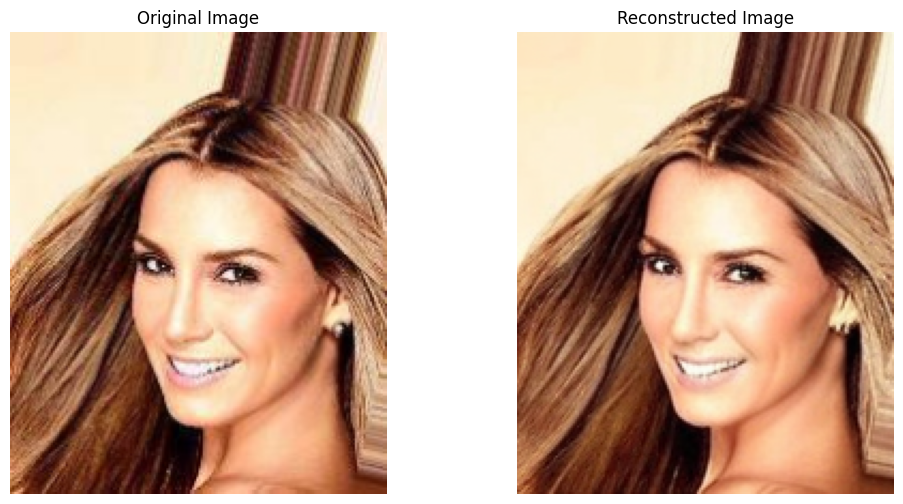

In [18]:
with torch.no_grad():
    # Move the tensors back to the CPU if they are on a GPU and remove the batch dimension
    img_cpu = tensor.squeeze(0).cpu()
    reconstruction_cpu = reconstruction.squeeze(0).cpu()

    # Convert the tensors to numpy arrays for plotting
    img_np = img_cpu.permute(1, 2, 0).numpy()
    reconstruction_np = reconstruction_cpu.permute(1, 2, 0).numpy()

    # Rescale the reconstructed image from [-1, 1] to [0, 1]
    img_np = (img_np + 1) / 2
    reconstruction_np = (reconstruction_np + 1) / 2

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Hide the axes

    # Display the reconstructed image
    axes[1].imshow(reconstruction_np)
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')  # Hide the axes

    # Show the plot
    plt.show()

In [19]:
def strings_to_tensor(string_list):
    """
    Converts a list of strings, each representing a list (e.g., "[1, 2, 3]"), 
    into a PyTorch tensor.

    Args:
        string_list (list of str): A list of strings, where each string is a list in string form.

    Returns:
        torch.Tensor: A PyTorch tensor containing the data from the lists.
    """
    # Convert each string to a list using eval
    list_of_lists = [eval(s) for s in string_list]
    
    # Convert the list of lists to a PyTorch tensor
    tensor = torch.tensor(list_of_lists, dtype=torch.float32)
    
    return tensor

In [20]:
def random_mask(bs: int, height: int, width: int, patch_size: int, mask_ratio: float, device: str = "cuda") -> torch.Tensor:
    """
    Generates a random mask for patched images. Randomly selects patches to mask.

    Args:
        bs (int): Batch size.
        height (int): Height of the image.
        width (int): Width of the image.
        patch_size (int): Size of the patches.
        mask_ratio (float): Ratio of patches to mask. Ranges from 0 to 1.

    Returns:
        mask (torch.Tensor): A tensor of shape (bs, num_patches) with values in {0, 1}.
    """
    num_patches = (height // patch_size) * (width // patch_size)
    num_patches_to_mask = int(num_patches * mask_ratio)
    
    # Create a tensor of random values
    rand_tensor = torch.rand(bs, num_patches, device=device)
    
    # Sort the random tensor and get the indices
    _, indices = torch.sort(rand_tensor, dim=1)
    
    # Create a mask tensor initialized with ones
    mask = torch.ones(bs, num_patches, device=device)
    
    # Set the first num_patches_to_mask indices to 0 for each batch
    mask[torch.arange(bs).unsqueeze(1), indices[:, :num_patches_to_mask]] = 0
    
    # Ensure the final shape is (bs, num_patches)
    mask = mask.view(bs, num_patches)

    return mask

In [27]:
input_dim = 4  # 4 channels in latent space
patch_size = 2 
embed_dim = 1152
num_layers = 12
num_heads = 4
mlp_dim = 4608
class_label_dim = 40  # 40 attributes in CelebA dataset

In [28]:
model = MicroDiffusion(input_dim, patch_size, embed_dim, num_layers, num_heads, mlp_dim, class_label_dim)
model = model.to(device)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
for batch in train_dl:
    images = batch["image"].to(device)
    image_prompts = strings_to_tensor(batch["prompt_string"]).to(device)
    latents = vae.encode(images).latent_dist.sample().to(device)

    noise = torch.randn_like(latents, device=device)
    # Between 0 and 1
    noise_amt = torch.rand(bs, device=device)

    noised_latents = latents * (1 - noise_amt.view(bs, 1, 1, 1)) + noise * noise_amt.view(bs, 1, 1, 1)

    mask = random_mask(bs, latents.shape[-2], latents.shape[-1], patch_size, 0.5)
    
    optimizer.zero_grad()

    pred = model(noised_latents, noise_amt * 1000, image_prompts, mask)

    loss = loss_fn(pred, latents)

    loss.backward()
    optimizer.step()

    print(loss)


torch.Size([4, 143, 768])
torch.Size([4, 768])


RuntimeError: prob_dist must be 1 or 2 dim